In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# theme = A Deep Learning Framework based on LSTM and data augmentation for lameness prediction in dairy cattle
# tools = Python, Numpy, Pandas, Keras, Tensorflow, Sklearn and Matplotlib
# author = Dylan Lebatteux
# date = 10/09/21

In [2]:
###############
### Imports ###
###############
import os
import csv
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization

In [3]:
###########################
### Basic configuration ###
###########################

# Ignore warnings about deprecated features
warnings.simplefilter(action = "ignore")

# Check the number of available GPUs
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Number of GPUs Available:", len(physical_devices))

# Set if memory growth should be enabled for a PhysicalDevice
if physical_devices: tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs Available: 1


In [4]:
############################################
#### Generation of the score dictionary  ### 
############################################

# Initialize the score dictionary
scores = {}
# Opening the score csv file
with open("scores.csv", mode = "r", encoding = "utf-8-sig") as file:
  # Reading the csv file
  scoreFile = csv.reader(file, delimiter = ";")
  # Save the contents of the CSV file
  for lines in scoreFile: 
    id = lines[0]
    score = lines[1]
    scores[id] = score

In [5]:
######################################################
### Generation of the locomotion matrix dictionary ###
######################################################

# Get the list of locomotion data files 
listLocomotionData = os.listdir("Locomotion")

# Initialize the data dictionary
data = {}
# Get the list of sensor names
sensor_names = pd.read_excel("Locomotion/" + listLocomotionData[0]).columns

# Iterate through the score dictionary
for key, value in scores.items(): 
  # Iterate through the list of locomotion data files 
  for locomotion in listLocomotionData: 
    if key in locomotion:
      df = pd.read_excel ("Locomotion/" + locomotion)
      df = df.dropna(how = "all")
      df = df.fillna(0)
      df = df.to_numpy()
      data[key] = df

In [6]:
######################################
### Set dimensions of the matrices ###
######################################

# Initialize the number of rows and columns
n_rows = []
n_columns = 60

# Iterate through the data dictionary
for key, value in data.items(): 
  # Save the number of rows of the actual array
  n_rows.append(value.shape[0])
# Set the number of rows for all arrays with he minimal value
n_rows = max(n_rows)
# Print the number of rows and columns
print("COLUMNS:", n_columns, "ROWS:", n_rows)

COLUMNS: 60 ROWS: 502


In [7]:
#############################################################
### Generation of matrices and imputation of missing data ###
#############################################################

# Initialize the feature matrix and the class vector
X = []
y = []

# Iterate through the data dictionary
for key, value in data.items():
  
  # Build the features matrix
  if scores[key] == "2" or scores[key] == "2,5" or scores[key] == "3" or scores[key] == "3,5":
    matrix = []
    for i in range(n_columns):
      sequence = []
      for j in range(n_rows):
        try: sequence.append(float(value[j][i]))
        except:sequence.append(float(0))
      sequence = np.array(sequence)
      matrix.append(sequence)
    matrix = np.array(matrix)
    X.append(matrix)

    # Save the classes
    if scores[key] == "2": y.append(0)
    elif scores[key] == "2,5":y.append(1)
    elif scores[key] == "3":y.append(2)
    elif scores[key] == "3,5" :y.append(3)
    else: pass

# Transform the matrix avec vector to numpy array
X = np.array(X)
y = np.array(y)

In [8]:
#############################
### Get data informations ###
#############################
n_instances = X.shape[0]
n_features = X.shape[1]
n_values = X.shape[2]
print("Number of instances =", n_instances, 
      "\nNumber of features per instance =", n_features, 
      "\nNumber of values per feature =", n_values)

Number of instances = 74 
Number of features per instance = 60 
Number of values per feature = 502


In [9]:
#####################################
### Display the data informations ###
#####################################
print("Matrice =", X.shape)
print("Classes =", set(y))
print("Example of instance =\n", X[0])
print("First value of the first feature of the first instance =", X[0][0][0])
print("Middle value of the middle feature of the middle instance =", X[int(n_instances / 2)][int(n_features /2)][int(n_values /2)])
print("Last value of the last feature of the last instance =", X[n_instances - 1][n_features - 1][n_values - 1])

Matrice = (74, 60, 502)
Classes = {0, 1, 2, 3}
Example of instance =
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First value of the first feature of the first instance = 0.0
Middle value of the middle feature of the middle instance = 29.043
Last value of the last feature of the last instance = 0.0


In [10]:
#################################
### Perform data augmentation ###
#################################

# Initialize the feature matrix and the class vector for generated data
X_Generated = []
y_Generated = []

# Set the variables
variation_percentage = 5

# Iterate through the instances of X
for i, x in enumerate(X):
    
    # Set the number of instance to generate balanced dataset
    if y[i] == 0: n_generated_instances = 125
    if y[i] == 1: n_generated_instances = 84
    if y[i] == 2: n_generated_instances = 132
    if y[i] == 3: n_generated_instances = 500
    
    # Iterate through the inumber of instances to generate
    for j in range(int(n_generated_instances)):
        # Initialize the vector to save the new matrix
        x_Generated = []
        # Iterate through the row of the actual instance
        for row in x:
            # Initialize the vector to save the new row
            x_Generated_Row = []
            # Iterate through the value of the actual row
            for value in row:
                # Generate random variation for the instance
                random_number = random.random()  * variation_percentage / 100
                # Generate boolen to add or remove the variation
                boolean = random.randint(0 , 1)
                # Save value adding variation
                if boolean == 0: x_Generated_Row.append(value + value * random_number)
                # Save value removing variation
                else: x_Generated_Row.append(value - value * random_number)
            # Convert the row vector to numpy array
            x_Generated_Row = np.array(x_Generated_Row)
            # Save the row vector
            x_Generated.append(x_Generated_Row)
        # Convert the matrix vector to numpy matrix
        x_Generated = np.array(x_Generated)
        # Save the generated matrix
        X_Generated.append(x_Generated)
        # Save the associated classes
        y_Generated.append(y[i])

# Transform the matrix avec vector to numpy array
X_Generated = np.array(X_Generated)
y_Generated = np.array(y_Generated)

In [11]:
#####################################
### Display the data informations ###
#####################################
print("Matrice =", X_Generated.shape)
print("Classes =", set(y_Generated))
print("Example of instance =\n", X_Generated[0])
print("First value of the first feature of the first instance =", X_Generated[0][0][0])
print("Middle value of the middle feature of the middle instance =", X_Generated[int(n_instances / 2)][int(n_features /2)][int(n_values /2)])
print("Last value of the last feature of the last instance =", X_Generated[n_instances - 1][n_features - 1][n_values - 1])

Matrice = (10028, 60, 502)
Classes = {0, 1, 2, 3}
Example of instance =
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First value of the first feature of the first instance = 0.0
Middle value of the middle feature of the middle instance = 197.80994923332017
Last value of the last feature of the last instance = 0.0


In [12]:
#################################
### Generate Train/Test Split ###
#################################
X_train, X_test, y_train, y_test = train_test_split(X_Generated, y_Generated, test_size = 0.20, random_state = 42)
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)

X_train shape = (8022, 60, 502)
X_test shape = (2006, 60, 502)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 32)            68480     
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 32)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 64)            256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 128)           9

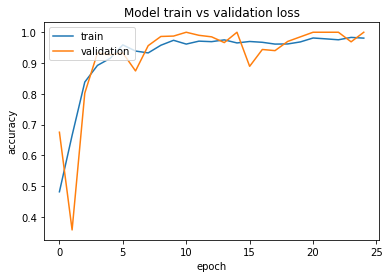

In [13]:
########################
### LSTM Model Train ###
########################

# Build model
model = Sequential()
model.add(LSTM(32, input_shape = (n_features, n_values), return_sequences = True))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LSTM(32))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation = 'softmax'))

# Display summary of the model
model.summary()

# Compile the model
model.compile(optimizer = "rmsprop", loss = sparse_categorical_crossentropy, metrics = ["accuracy"])

# Fit the model
history = model.fit(x = X_train, y = y_train, validation_split = 0.10, epochs = 25, shuffle = True, verbose = 1)

# Plot the history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model train vs validation loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

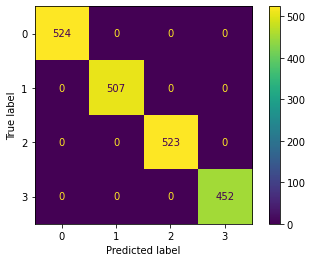


Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       524
           1      1.000     1.000     1.000       507
           2      1.000     1.000     1.000       523
           3      1.000     1.000     1.000       452

    accuracy                          1.000      2006
   macro avg      1.000     1.000     1.000      2006
weighted avg      1.000     1.000     1.000      2006



In [14]:
#######################
### LSTM Model Test ###
#######################

# Predict test data
y_pred = model.predict(x = X_test)

# Convert to rounded prediction
y_pred = np.argmax(y_pred, axis = -1)

# Compute confusion matrix
cm = confusion_matrix(y_true = y_test , y_pred=y_pred)

# Set the labels
target_names = ['0','1','2','3']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
disp = disp.plot()
plt.show()

# Display the classification report
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names = target_names, digits = 3))